In [14]:
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
from glob import glob

import matplotlib.pyplot as plt

import rioxarray as rio
from shapely.geometry import mapping

%matplotlib inline
# %matplotlib widget

In [2]:
# wrap locating of the median points into a function: 

### (1) read .shp

In [4]:
hma = gpd.read_file('HMA_regions/HMA_regions.shp')
# hma.plot()

# as dataframe
hma_df = pd.DataFrame(hma) 

### (2) read climate

In [5]:
climate = xr.open_mfdataset('*.nc', decode_coords="all")
# cnange units (and overwrite the metadata with the units after)

# ------ UNITS ------

#convert temperature K to C
climate['t2m']=climate.t2m-273.15
# precipotation m to mm 
climate['tp']=climate.tp * 1000
# radiation j/m2 to w/m2
# SSR [W/m2] = SSR [J/m^2] / (3600 seconds)
climate['ssrd'] = climate.ssrd / 3600

# ------ CRS ----------

# add crs to the dataset (netcdf file) - maybe this is not even needed 
climate = climate.rio.write_crs('EPSG:4326')



In [6]:
#

climate_median = climate.median(dim='time', keep_attrs = True, skipna=True)

# climate_median

In [7]:
# hma = hma[hma['Name'] == hma_df.Name[21]]

hma = hma[:3]

In [9]:
# hma

### (3) function: 

In [10]:
# function for median: 

def median_ceil(values):
    values = sorted(values)
    values_len = len(values)
    middle = values_len//2
    return values[middle]


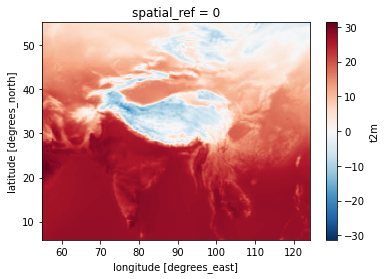

In [11]:
climate_median.t2m.plot()

In [12]:
%%time
# for every geometry in hma

# t2m_median = roi_climate_median_df[roi_climate_median_df.t2m==median_ceil(values=roi_climate_median_df.t2m)]

name = []
value = []
lats = []
lons = []


for r in hma.values:
    
    # name:
    roi_name = str(hma.Name)
    name = np.append(name, roi_name)
    
    # clip:
    clipped = climate_median.rio.clip(hma.geometry, hma.crs, drop=True, invert=False)
    
    # sanity check
    # clipped.t2m.plot()
    
    # to dataframe:
    df = clipped.to_dataframe().reset_index()
    df = df.dropna().drop_duplicates()
    
    # median vallues for a parameter: 
    median_value = median_ceil(values=df.t2m)
    # print('temp median value', median_value)
    
    # find index of this value:
    row = df[df.t2m == median_value]
    lat = row.latitude.values[0]
    lon = row.longitude.values[0]
    
    #add:
    value = np.append(value, median_value)
    lats = np.append(lats, lat)
    lons = np.append(lons, lon)

    # print('name:', name)
    # print('lat', lat)
    # print('lon', lon)

    

CPU times: user 2min, sys: 50.4 s, total: 2min 51s
Wall time: 3min 17s


In [ ]:
lats
lons
value
name

In [17]:
table = pd.DataFrame([name, lats, lons, value]).transpose()

In [18]:
table

,0,1,2,3
0,0 Eastern Hindu Kush\n1 Western Himala...,27.75,90.5,1.485031
1,0 Eastern Hindu Kush\n1 Western Himala...,27.75,90.5,1.485031
2,0 Eastern Hindu Kush\n1 Western Himala...,27.75,90.5,1.485031


In [19]:
name

array(['0    Eastern Hindu Kush\n1      Western Himalaya\n2      Eastern Himalaya\nName: Name, dtype: object',
       '0    Eastern Hindu Kush\n1      Western Himalaya\n2      Eastern Himalaya\nName: Name, dtype: object',
       '0    Eastern Hindu Kush\n1      Western Himalaya\n2      Eastern Himalaya\nName: Name, dtype: object'],
      dtype='<U97')